<a href="https://colab.research.google.com/github/jghcobussen/PRA3024/blob/master/Week_2_Astronomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creator: Joyce Cobussen 

Date:    11/02/2020

Purpose: This notebooks summarizes and demonstrates several data analysis methods for transit data of exoplanets and observational data of variable stars. The code and its physical interpretation are briefly explained in the comments.

In [1]:
# Modules that need to be important for each of the parts of this notebook

# Part I
!pip install astroquery 
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Part II
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
%matplotlib inline

#Part III
import requests
import pandas as p
from IPython.display import display, HTML

#Part IV
from astroquery.mast import Tesscut, Observations, Catalogs
from astropy.table import Table
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()



     |████████████████████████████████| 4.5MB 4.6MB/s 
     |████████████████████████████████| 2.3MB 49.9MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=f4ed23f0670666371a23b4fd6167ccb9b494df163947a7233feb9f89c406e24e
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
Successfully built astroquery


Part I: Creating a Flux vs. Phase plot for stars with exoplanet orbiting around them

In [0]:
# Select a start that (possibly) has planets orbiting around

star_name = "HR 858"

observations = Observations.query_object(star_name,radius = "0 deg")
obs_wanted = (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS')

In [8]:
data_products = Observations.get_product_list(observations[obs_wanted])
products_wanted = Observations.filter_products(data_products, 
                                    productSubGroupDescription=["DVT","DVM","DVS","DVR"])

manifest = Observations.download_products(products_wanted)

INFO: Found cached file ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-00135_dvr.pdf with expected size 24278294. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-00135_dvr.xml with expected size 273005. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-00135_dvm.pdf with expected size 5900346. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-01-00135_dvs.pdf with expected size 736959. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-02-00135_dvs.pdf with expected size 762947. [astroquery.que

In [9]:
def parse_manifest(manifest):
    """
    Parse manifest and add back columns that are useful for TESS DV exploration.
    """
    results = deepcopy(manifest)
    filenames = []
    sector_range = []
    exts = []
    for i,f in enumerate(manifest['Local Path']):
        file_parts = np.array(np.unique(f.split(sep = '-')))
        sectors = list( map ( lambda x: x[0:2] == 's0', file_parts))
        s1 = file_parts[sectors][0]
        try:
            s2 = file_parts[sectors][1]
        except:
            s2 = s1
        sector_range.append("%s-%s" % (s1,s2))
        path_parts = np.array(f.split(sep = '/'))
        filenames.append(path_parts[-1])
        exts.append(path_parts[-1][-8:])

    results.add_column(table.Column(name = "filename", data = filenames))
    results.add_column(table.Column(name = "sectors", data = sector_range))
    results.add_column(table.Column(name = "fileType", data = exts))
    results.add_column(table.Column(name = "index", data = np.arange(0,len(manifest))))
    
    return results

# Run the parser method and print the results
results = parse_manifest(manifest)
print(results['index','sectors','fileType'])

index   sectors   fileType
----- ----------- --------
    0 s0004-s0004 _dvr.pdf
    1 s0004-s0004 _dvr.xml
    2 s0004-s0004 _dvm.pdf
    3 s0004-s0004 _dvs.pdf
    4 s0004-s0004 _dvs.pdf
    5 s0004-s0004 dvt.fits


In [10]:
# Print the results of the sectors containing most information. In this case, only the sector s0004 exists, so that is the one to select.

print(results['index', 'sectors', 'fileType'][results['sectors'] == "s0004-s0004"])

index   sectors   fileType
----- ----------- --------
    0 s0004-s0004 _dvr.pdf
    1 s0004-s0004 _dvr.xml
    2 s0004-s0004 _dvm.pdf
    3 s0004-s0004 _dvs.pdf
    4 s0004-s0004 _dvs.pdf
    5 s0004-s0004 dvt.fits


In [11]:
# Locate the file that contains the data
want = (results['sectors'] == "s0004-s0004") & (results['fileType'] == "dvt.fits")
dvt_filename = manifest[want]['Local Path'][0]

# Print out the information contained in the corresponding file
fits.info(dvt_filename)

Filename: ./mastDownload/TESS/tess2018292075959-s0004-0000000178155732-0124-s/tess2018292093540-s0004-s0004-0000000178155732-00135_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  TCE_1         1 BinTableHDU     92   18684R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU     92   18684R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  Statistics    1 BinTableHDU    157   18684R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


Text(0.5, 1.0, 'Data Validation Detrended Light Curve for HR 858')

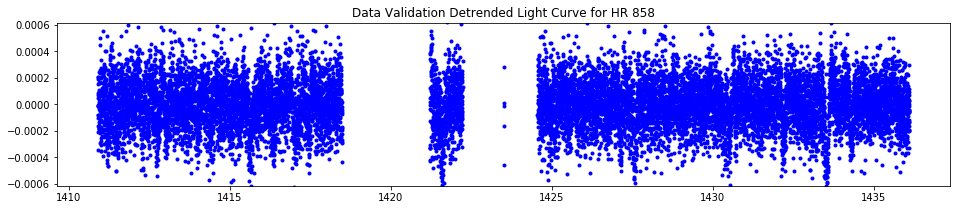

In [12]:
# Create a plot of the detrended photometric time series in the first binary table. 
# Detrended means that trends due to random and systematic errors caused by for example changes in air mass or vibrational noise is filtered out. 
data = fits.getdata(dvt_filename, 1)
time = data['TIME']
relflux = data['LC_DETREND']

plt.figure(figsize = (16,3))
plt.plot (time, relflux, 'b.')
plt.ylim(1.2* np.nanpercentile(relflux, .5) , 1.2 * np.nanpercentile(relflux, 99.5))
plt.title('Data Validation Detrended Light Curve for %s' % (star_name))

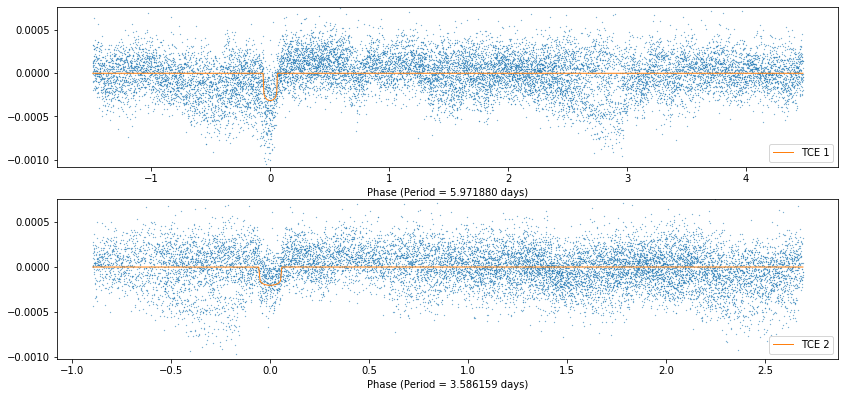

In [13]:
# Plot all phases, obtained from fourier analysis, over one another to create a flux vs. phase plot

def plot_folded(phase, data, model, ext, period):
    isort = phase.argsort()
    
    plt.plot(phase[isort], data[isort], '.', ms = .5)
    plt.plot(phase[isort], model[isort], '-', lw = 1, label = "TCE %i" % ext)
    plt.xlabel('Phase (Period = %3.6f days)' % period)
    plt.ylim(1.5 * np.nanpercentile(data, .5) , 1.4 * np.nanpercentile(data,99.5))
    plt.legend(loc = "lower right")

plt.figure(figsize = (14,10))

nTCEs = fits.getheader(dvt_filename)['NEXTEND'] - 2

for ext in range(1, nTCEs + 1):
    data = fits.getdata(dvt_filename, ext)
    head = fits.getheader(dvt_filename, ext)
    period = head['TPERIOD']
    phase = data['PHASE']
    flux = data['LC_INIT']
    model = data['MODEL_INIT']
    plt.subplot(3, 1, ext)
    plot_folded(phase, flux, model, ext, period)

Interestingly, only two plots show while the Tess data website shows three confirmed planets. This may indicate that the third planet is very small, resulting in very faint observational effects that could be even smaller than the threshold for noise. It could also be that the planet has a comparatively long orbital period, resulting in little available data which the program may  consider not to be significant enough. 

Part II: Plotting the spectrum of a pulsar


In [52]:
# Select a star of interest and define it's tic id. In this case, the pulsating helium-atmosphere white dwarf with TIC ID 257459955 was chosen. For full article, see:
# Bell, Keaton J. et al. “TESS First Look at Evolved Compact Pulsators.” Astronomy & Astrophysics 632 (2019): A42. Crossref. Web.


ticid = 257459955

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table

print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

KeyboardInterrupt: ignored

In [17]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.

bright = catalogData['Tmag'] < 15

nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

5

In [18]:
# Check which sector contains data of the chosen star 

coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0003-1-2      3      1   2


In [25]:
hdulist = Tesscut.get_cutouts(coord, 20)

hdulist[0].info()
hdulist[0][0].header['SECTOR']

hdulist[0].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1288R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1288R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


In [0]:
# Define a function. This will simplify the code we need later

def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

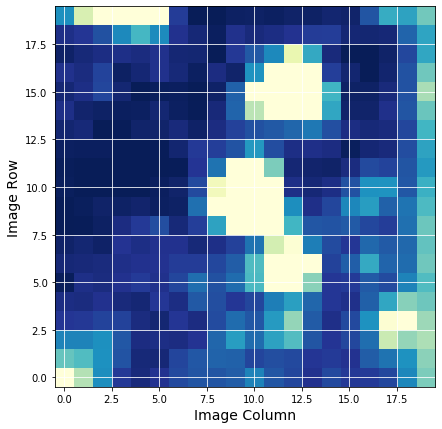

In [27]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

# Plot the flux data 

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

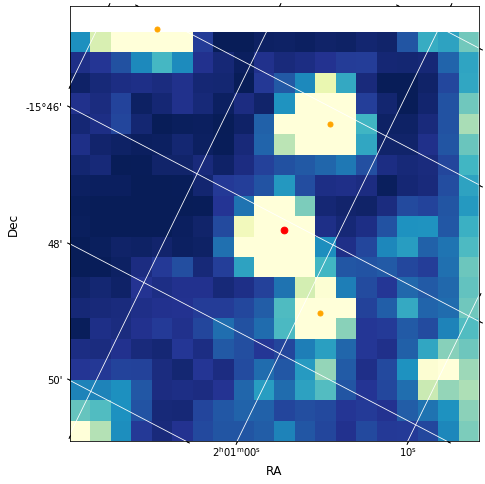

In [29]:
hdu2 = hdulist[0]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.

nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux


Text(0.5, 1.0, 'Flux in Photometric Aperture')

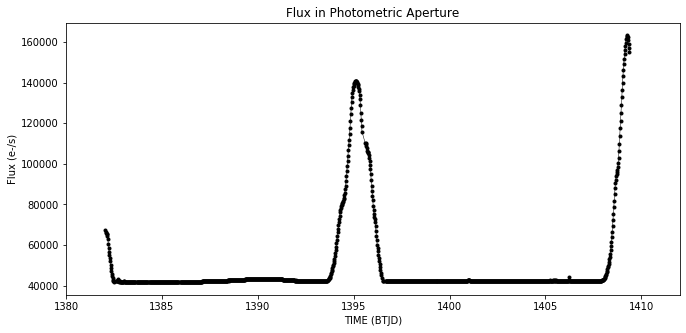

In [35]:
# Use all the pixels in our aperture to create a flus vs. time plot. 

# To select the right time, look for the dates between which the appropriate sector(s) were plotted. Convert this to Barycentric Julian Data using any online converter and subtract 2457000 days. 

aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1380, 1412)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

Text(0.5, 1.0, 'Background Flux')

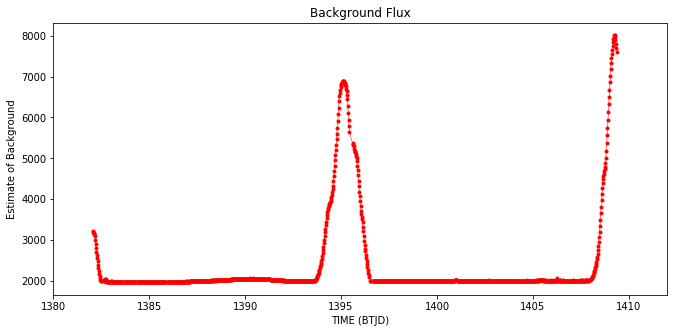

In [37]:
# Generate a plot of the background flux. To do so, plot the flux change of the dimmest pixels by using percentile.

bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1380, 1412)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Text(0.5, 1.0, 'Background Subtracted Flux')

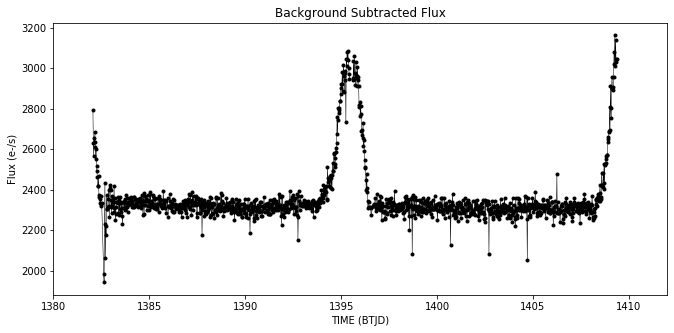

In [39]:
# Subtract the background flux from the data to obtain a more accurate plot

bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

# Range by looking at sector dates, converting to julian dates (IDL - 2457000) 

plt.xlim(1380, 1412)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

Part III: Plotting a planet

In [0]:
# Define the planet url from which to get the planet table, and the data validation url from which to get the header and light curve.

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

In [0]:
# Choose a planet (https://exo.mast.stsci.edu/exomast_planet.html?planet=CoRoT-12%20b). Specifically, ensure that Tess light curve data is available

planet_name = "CoRoT-12 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)

In [42]:
# Print the planet's information

planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'CoRoT-12 b',
 'dec': -1.2964166662428112,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': ['UCAC2 31290403 b',
  'GSC2 S10031006251 b',
  'CoRoT 102671819 b',
  'USNO-A2.0 0825-03015398 b',
  'CoRoT-12 b',
  'UCAC3 178-45452 b',
  '2MASS J06430376-0117471 b',
  'USNO-B1.0 0887-00101512 b'],
 'ra': 100.76567500034969,
 'starName': 'CoRoT-12',
 'tessID': 280210963,
 'tessTCE': 'TCE_1'}

In [43]:
# Investigate the planet properties that can be utilized 

url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

Catalog 1: exoplanets.org
Catalog 2: nexsci


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [45]:
# Print selected properties of the chosen planet

print("CoRoT-12 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

CoRoT-12 b Properties
Stellar Mass 1.078000 M_sun
Planet Mass 0.919180 M_Jupiter
Planet Mass Reference: Calculated from MSINI and I


In [46]:
# Check in which sector(s) the data is(/are) available

url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0006-s0006']

In [47]:
# Retrieve the planet's TIC code

url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 280210963
Planet Radius: 28.355120


In [0]:
# Request the relevant TCE data

url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [49]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

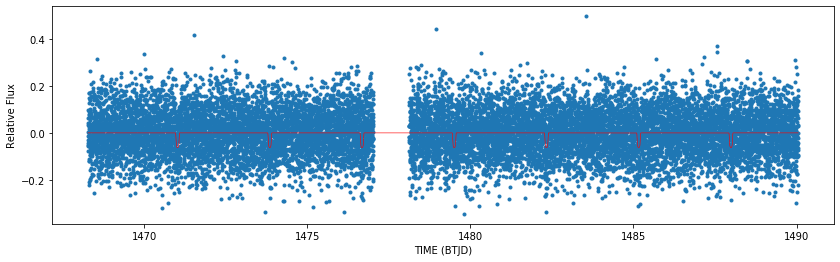

In [50]:
# Create a plot of the light curve data for the chosen planet

detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

In [53]:
# Plot the phases acquired through fourier analysis over each other for all available data

url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

display(HTML(str(r.content.decode('utf-8'))))

The plot shows visible dip, although there seems to be a lot of noise. Seeing as the number of data points is not very large either, performing more observations will most likely lead to a more accurate fit to the transit curve.

Part IV: Visualizing a solar flare


In [0]:
#Select a star of interest. In this case, data was acquired from https://arxiv.org/pdf/1901.00443.pdf

tic_id = 167695269
sector = 1

tpeak = 2458343.026 # Julian Day

In [55]:
mission_res = Observations.query_criteria(obs_collection="TESS", 
                                          target_name=tic_id, 
                                          sequence_number=sector)
mission_res

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str10,int64,str4,str47,str9,float64,float64,float64,float64,float64,str7,str4,float64,float64,str1,str1,float64,str10,str14,str7,str1,str4,int64,str4,str48,str1,str73,str6,bool,float64,str7,str11,str11
timeseries,3,TESS,tess2018206045859-s0001-0000000167695269-0120-s,167695269,102.88298700066662,-64.00836200059697,58324.79285543,58352.6761776,120.0,Optical,TESS,600.0,1000.0,--,--,58458.58333,Photometer,"Ricker, George",G011180,--,TESS,1,SPOC,CIRCLE ICRS 102.88298700 -64.00836200 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000167695269-0120-s_lc.fits,PUBLIC,False,nan,science,17000000910,17002456778


In [56]:
tasoc_res = Observations.query_criteria(target_name=tic_id, 
                                        obs_collection="HLSP", 
                                        project="TESS",
                                        sequence_number=sector)
tasoc_res['dataproduct_type',"obs_collection","target_name","t_exptime","filters",
          "provenance_name","project","sequence_number","instrument_name"]

dataproduct_type,obs_collection,target_name,t_exptime,filters,provenance_name,project,sequence_number,instrument_name
str10,str4,str9,float64,str4,str5,str4,int64,str10
timeseries,HLSP,167695269,120.0,TESS,TASOC,TESS,1,Photometer
timeseries,HLSP,167695269,1800.0,TESS,TASOC,TESS,1,Photometer


In [57]:
tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

dataproduct_type,description,dataURI,size
str10,str4,str107,int64
timeseries,FITS,mast:HLSP/tasoc/s0001/tpf/0000/0001/6769/5269/hlsp_tasoc_tess_ffi_tic00167695269-s01-c0120_tess_v04_lc.fits,1877760
timeseries,FITS,mast:HLSP/tasoc/s0001/ffi/0000/0001/6769/5269/hlsp_tasoc_tess_ffi_tic00167695269-s01-c1800_tess_v04_lc.fits,161280


In [58]:
tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

Local Path,Status,Message,URL
str138,str8,object,object
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00167695269-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00167695269-s01-c0120_tess_v04_lc.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00167695269-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00167695269-s01-c1800_tess_v04_lc.fits,COMPLETE,None,None


In [0]:
# Load the short and long cadence light curves, respectively
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

hdu = fits.open(tasoc_manifest["Local Path"][1])
long_cad_lc = Table(hdu[1].data)
hdu.close()

In [60]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tic_id})")

# Short cadence
bfig.circle(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], fill_color="black",size=2, line_color=None)
bfig.line(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], line_color='black')

# Long cadence
bfig.circle(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], fill_color="#0384f7",size=6, line_color=None)
bfig.line(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], line_color='#0384f7')

# Marking the flare (tpeak is in BJD, while the time column in the light curve is BTJD, so we must convert)
vline = Span(location=(tpeak - 2457000), dimension='height', line_color='#bf006e', line_width=3)
bfig.renderers.extend([vline])

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

The detrended light curve above shows some irregularities between 1345 and 1350, indicating the time at which the flare happened. 

In [0]:
coord = Observations.resolve_object(f"TIC {tic_id}")

In [0]:
cutout_hdu = Tesscut.get_cutouts(coordinates=coord, size=40, sector=1)[0]

In [63]:
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (40, 40)   int32   


In [64]:
cutout_table = Table(cutout_hdu[1].data)
cutout_table.columns

TableColumns([('TIME', <Column name='TIME' dtype='float64' length=1282>
               1325.3230590820312
               1325.3438720703125
               1325.3646850585938
               1325.3855590820312
               1325.4063720703125
               1325.4271850585938
               1325.4480590820312
               1325.4688720703125
               1325.4896850585938
               1325.5105590820312
               1325.5313720703125
               1325.5521850585938
                              ...
               1352.9269409179688
                 1352.94775390625
               1352.9685668945312
               1352.9894409179688
                 1353.01025390625
               1353.0310668945312
               1353.0519409179688
                 1353.07275390625
               1353.0935668945312
               1353.1144409179688
                 1353.13525390625
               1353.1560668945312),
              ('TIMECORR', <Column name='TIMECORR' dtype='float32' length=12

In [68]:
start_btjd = 1348.50
end_btjd = 1349.50

start_index = (np.abs(cutout_table['TIME'] - start_btjd)).argmin()
end_index = (np.abs(cutout_table['TIME'] - end_btjd)).argmin()

print(f"Frames {start_index}-{end_index} ({end_index-start_index} frames)")

Frames 1058-1106 (48 frames)


In [0]:
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani

In [0]:
make_animation(cutout_table['FLUX'], start_index, end_index, vmax=700, delay=150)